In [296]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from allen_v1dd.client import OPhysClient
from allen_v1dd.duplicate_rois import get_duplicate_roi_pairs_in_session, get_unique_duplicate_rois, parse_duplicates_from_h5, save_duplicates_to_h5
from allen_v1dd.stimulus_analysis import analysis_tools as at

at.set_stylesheet()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [251]:
client = OPhysClient("chase")

In [252]:
session = client.load_ophys_session("M409828_13")

In [253]:
at.set_analysis_file("/Users/chase/Desktop/stimulus_analyses_v2.h5")

for session_group, _ in at.iter_plane_groups(filter=dict(mouse=session.get_mouse_id(), column=session.get_column_id(), volume=session.get_volume_id()), return_session_group=True):
    old_dups = parse_duplicates_from_h5(session_group)
    break

print(len(old_dups), "duplicates found in", session.get_session_id())

508 duplicates found in M409828_13


# Recompute best ROI based on the strongest dF/F trace

In [254]:
# Use high quantile as a proxy for trace strength
q = 0.995
trace_strength = {
    plane: session.get_traces(plane=plane, trace_type="dff").quantile(q, dim="time").values
    for plane in session.get_planes()
}

# Recompute the best ROI as the one with the strongest connection strength
dups = []
for dup_set in old_dups:
    dup_set = sorted(dup_set, key=lambda x: trace_strength[x[0]][x[1]], reverse=True) # copy and sort in descending order of trace strength
    
    # for plane, roi in dup_set:
    #     print(plane, roi, trace_strength[plane][roi])
    # break
    dups.append(dup_set)

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

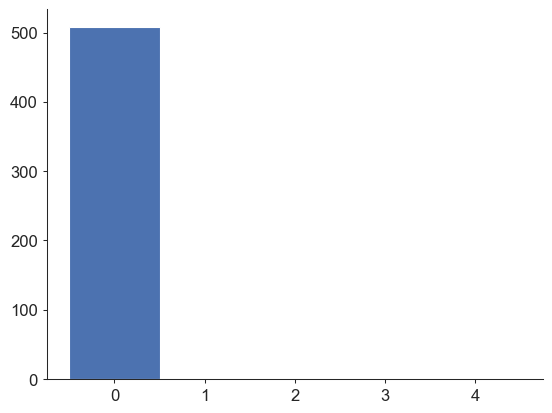

In [255]:
delta_plane = []

for old_dup_set, new_dup_set in zip(old_dups, dups):
    old_best, new_best = old_dup_set[0], new_dup_set[0]

    delta_plane.append(abs(new_best[0] - old_best[0]))

plt.hist(delta_plane, bins=np.array([0, 1, 2, 3, 4, 5])-0.5)
plt.xlabel

In [256]:
dups_of_size = {}

for dup_set in dups:
    n = len(dup_set)
    if n in dups_of_size:
        dups_of_size[n].append(dup_set)
    else:
        dups_of_size[n] = [dup_set]

for n in sorted(dups_of_size.keys()):
    d = len(dups_of_size[n])
    print(f"n = {n}: {d} ({d/len(dups)*100:.0f}%) duplicate groups")

n = 2: 339 (67%) duplicate groups
n = 3: 94 (19%) duplicate groups
n = 4: 39 (8%) duplicate groups
n = 5: 17 (3%) duplicate groups
n = 6: 19 (4%) duplicate groups


In [257]:
roi_to_best_plane = {} # (plane, roi) -> best_plane

for dup_set in dups:
    best_plane = dup_set[0][0]
    for roi in dup_set:
        roi_to_best_plane[roi] = best_plane

In [258]:
plane, roi = 1, 5
roi_mask = session.get_roi_image_mask(plane, roi)
y, x = np.mean(np.where(roi_mask), axis=1, dtype=int)
depth = session.get_plane_depth(plane)

print(x, y, depth)

197 185 258


# Examine falloff of trace strength for duplicate ROIs

[0.33814531 0.59378253 1.         0.5847953  0.33593694]


Text(0.5, 0, 'Plane relative to ROI plane')

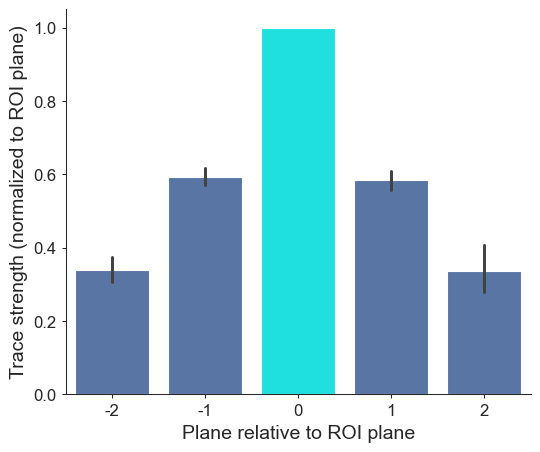

In [306]:
plane_span_width = 2
plane_strengths = np.full((len(dups), 2*plane_span_width+1), np.nan)

for i, dup_set in enumerate(dups):
    best_plane, best_roi = dup_set[0]

    for p, r in dup_set:
        if abs(p - best_plane) <= plane_span_width:
            plane_strengths[i, plane_span_width + best_plane - p] = trace_strength[p][r]

plane_strengths = plane_strengths / plane_strengths[:, [plane_span_width]]
print(np.nanmean(plane_strengths, axis=0))

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(plane_strengths, palette=["b", "b", "aqua", "b", "b"], ax=ax)
ax.set_ylabel("Trace strength (normalized to ROI plane)")
ax.set_xticklabels(range(-plane_span_width, plane_span_width+1))
ax.set_xlabel("Plane relative to ROI plane")

[0.79705818 0.932927   1.         0.91136206 0.84151512]


Text(0.5, 0, 'Plane relative to ROI plane')

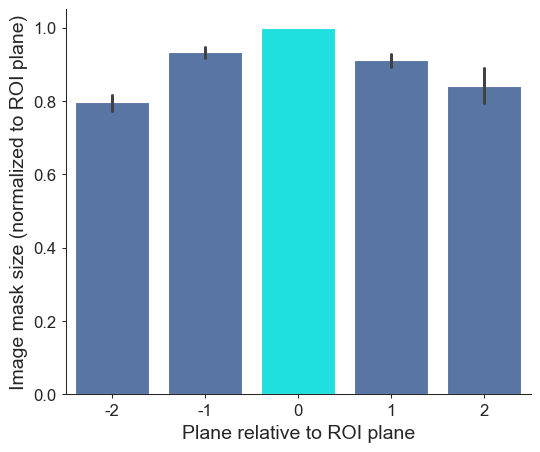

In [310]:
plane_span_width = 2
plane_strengths = np.full((len(dups), 2*plane_span_width+1), np.nan)

for i, dup_set in enumerate(dups):
    best_plane, best_roi = dup_set[0]

    for p, r in dup_set:
        if abs(p - best_plane) <= plane_span_width:
            plane_strengths[i, plane_span_width + best_plane - p] = np.sum(session.get_roi_image_mask(p, r))

plane_strengths = plane_strengths / plane_strengths[:, [plane_span_width]]
print(np.nanmean(plane_strengths, axis=0))

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(plane_strengths, palette=["b", "b", "aqua", "b", "b"], ax=ax)
ax.set_ylabel("Image mask size (normalized to ROI plane)")
ax.set_xticklabels(range(-plane_span_width, plane_span_width+1))
ax.set_xlabel("Plane relative to ROI plane")

# Examine ROI positions of 6-plane duplicates

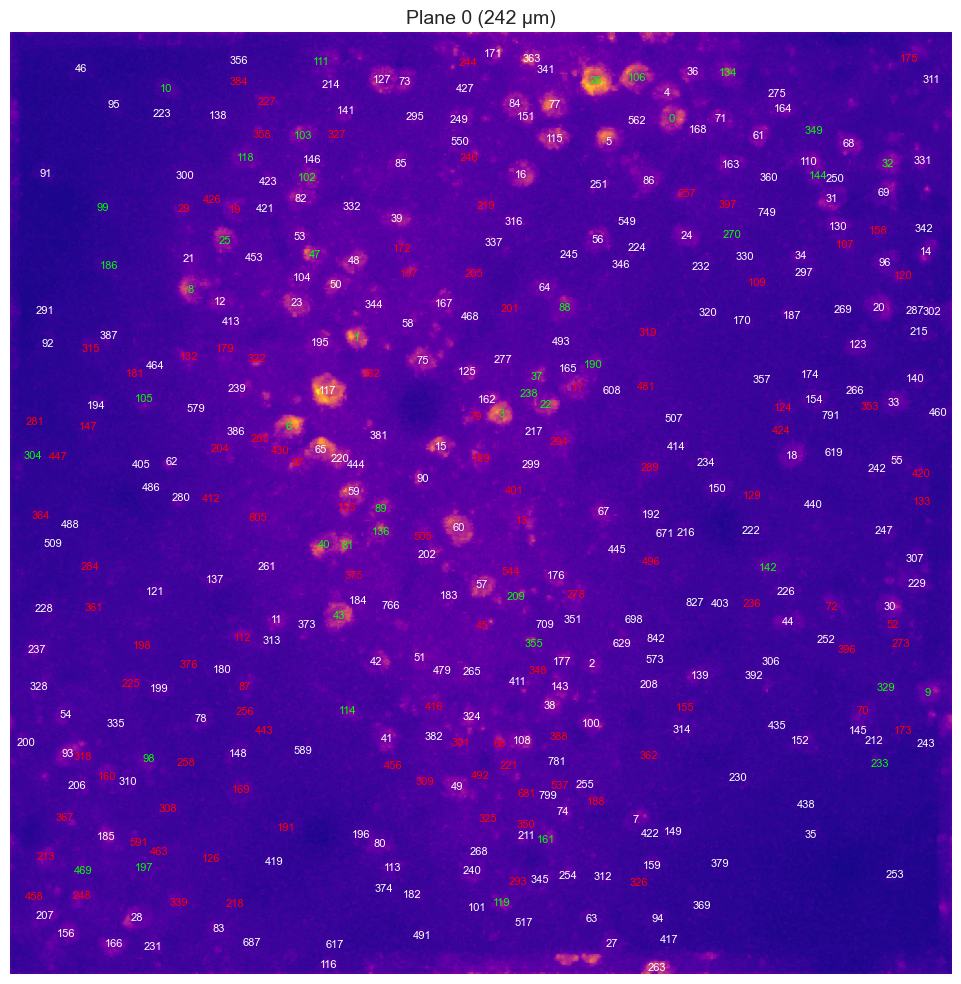

In [311]:
for plane in session.get_planes():
    proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = session.get_plane_projection_images(plane)
    depth = session.get_plane_depth(plane)
    fig, ax = plt.subplots(figsize=(10, 10), tight_layout=True)

    ax.axis("off")
    ax.imshow(proj_raw_max, cmap="plasma")
    ax.set_title(f"Plane {plane} ({depth} µm)")

    for roi in np.where(session.is_roi_valid(plane))[0]:
        roi_mask = session.get_roi_image_mask(plane, roi)
        y, x = np.mean(np.where(roi_mask), axis=1)

        if (plane, roi) in roi_to_best_plane:
            # ROI has duplicates
            if roi_to_best_plane[(plane, roi)] == plane:
                # This is the kept ROI
                color = "lime"
            else:
                # This is an ignored ROI
                color = "red"
        else:
            # ROI doesn't have duplicates
            color = "white"

        ax.text(x, y, f"{roi}", color=color, ha="center", va="center", fontsize=8)

    fig.savefig(f"/Users/chase/Desktop/M409828_13_2p_proj/Plane{plane}.png", dpi=150, bbox_inches="tight")
    
    if plane > 0:
        plt.close(fig)
        # break

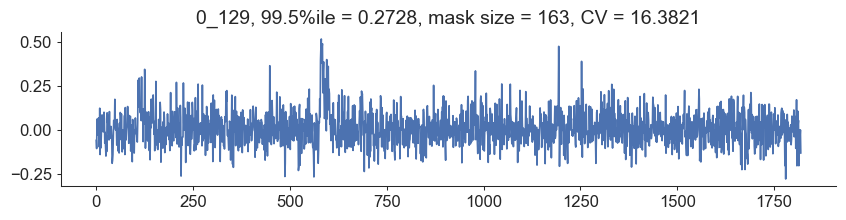

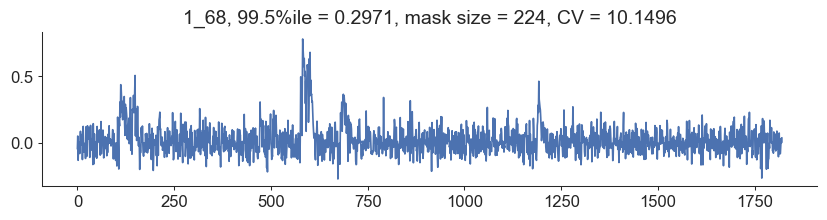

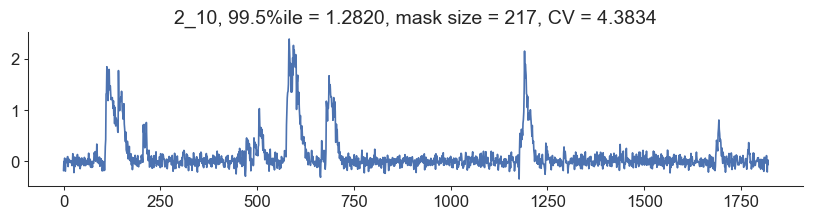

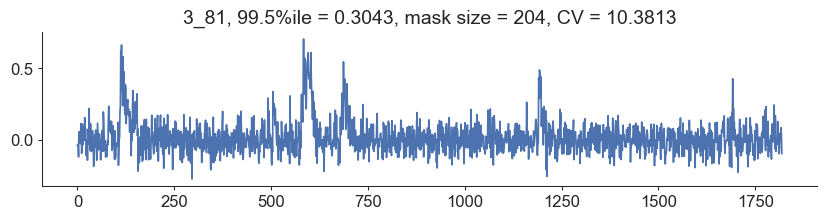

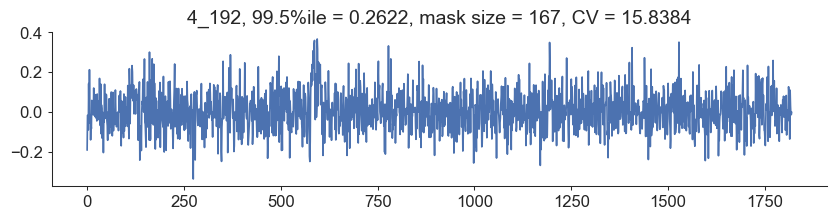

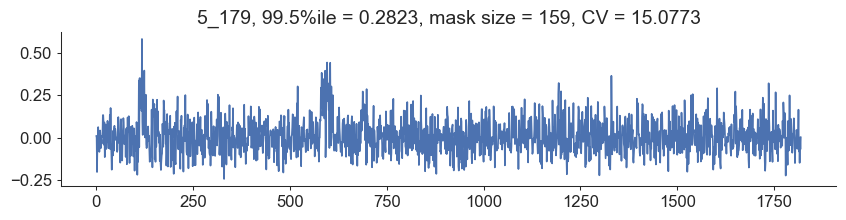

In [179]:
# for plane, roi in ((1, 27), (2, 11)):
for plane, roi in sorted(dups_of_size[6][2], key=lambda x: x[0]):
    plt.figure(figsize=(10, 2))
    all_traces = session.get_traces(plane=plane, trace_type="dff").sel(roi=roi)
    spont_traces = session.get_spont_traces(plane=plane, trace_type="dff").sel(roi=roi)
    plt.plot(spont_traces)
    # plt.plot(all_traces)
    mask_size = int(np.sum(session.get_roi_image_mask(plane, roi)))
    cv = np.std(all_traces) / np.mean(all_traces)
    plt.title(f"{plane}_{roi}, 99.5%ile = {np.quantile(all_traces, 0.99):.4f}, mask size = {mask_size}, CV = {cv:.4f}")

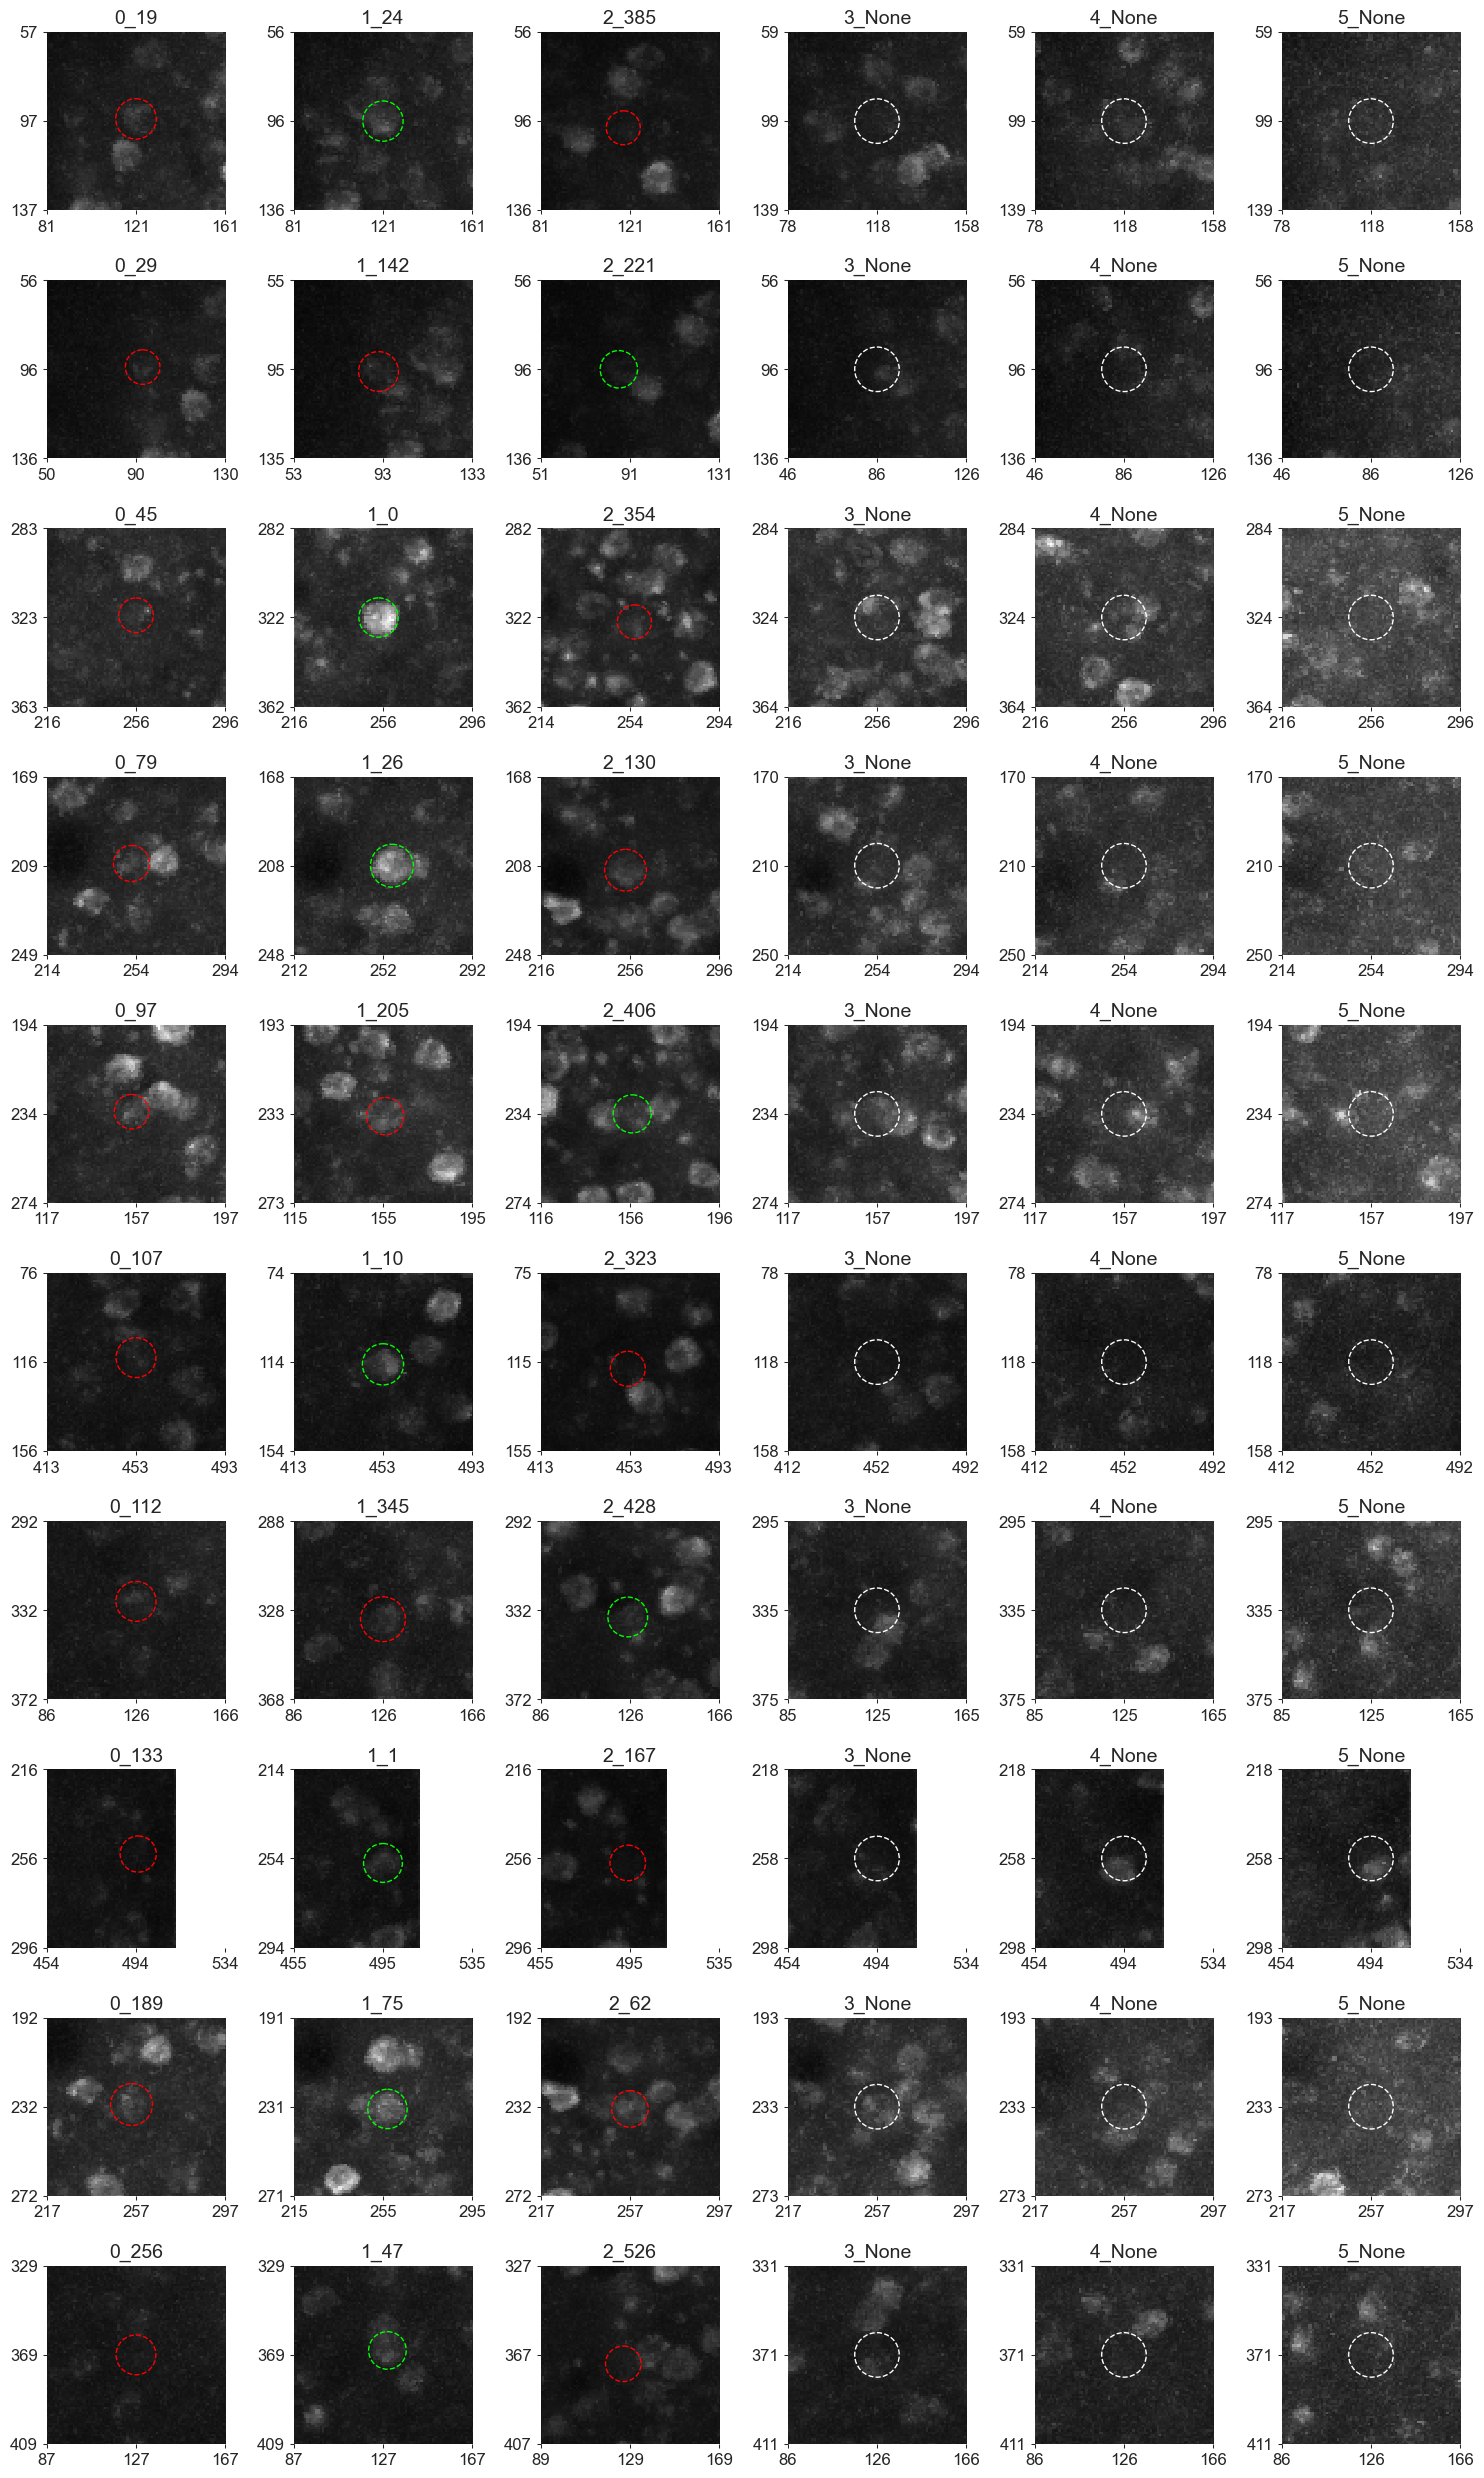

In [174]:
plane_proj_imgs = {}

for plane in session.get_planes():
    proj_raw_mean, proj_raw_max, proj_de_mean, proj_de_max, proj_de_corr = session.get_plane_projection_images(plane)
    plane_proj_imgs[plane] = proj_raw_max
    # plane_proj_imgs[plane] = proj_de_corr

img_rad = 40

for dup_set_size in [3]:
    nrows = min(10, len(dups_of_size[dup_set_size]))
    n_planes = 6
    # n_planes = dup_set_size
    fig, axs = plt.subplots(figsize=(n_planes*2.5, nrows*2.5), nrows=nrows, ncols=n_planes, tight_layout=True)

    for row in range(nrows):
        row_dups = dups_of_size[dup_set_size][row]
        # dup_set = sorted(dups_of_size[dup_set_size][row], key=lambda x: x[0]) # sort by plane
        dup_plane_to_roi = {}
        best_plane = row_dups[0][0]
        y = []
        x = []

        for plane, roi in row_dups:
            if plane in dup_plane_to_roi:
                print(f"WARN: duplicate plane for ROI {plane}-{roi}")
                continue
            dup_plane_to_roi[plane] = roi

            roi_mask = session.get_roi_image_mask(plane, roi)
            mask_size = int(np.sum(roi_mask))
            Y, X = np.median(np.where(roi_mask), axis=1)
            y.append(Y)
            x.append(X)
        
        y = int(np.mean(y))
        x = int(np.mean(x))

        for plane in range(n_planes):
            ax = axs[row, plane]
            roi = dup_plane_to_roi.get(plane)
            is_best_roi = plane == best_plane
            img = plane_proj_imgs[plane]#[y-fig_r:y+fig_r, x-fig_r:x+fig_r]
            ax_title = f"{plane}_{roi}"

            ax.set_title(ax_title)
            ax.imshow(img, cmap="gray", interpolation="nearest")
            ax.set_xlim(x-img_rad, x+img_rad)
            ax.set_ylim(y+img_rad, y-img_rad) # note y-axis is inverted

            # ax.axis("off")
            for spine in ax.spines: ax.spines[spine].set_visible(False)
            ax.set_xticks([x-img_rad, x, x+img_rad])
            ax.set_yticks([y+img_rad, y, y-img_rad])

            if roi is not None:
                roi_mask = session.get_roi_image_mask(plane, roi)
                mask_size = int(np.sum(roi_mask))
                y, x = np.mean(np.where(roi_mask), axis=1)
                y = int(y)
                x = int(x)
                # ax.imshow(roi_mask, cmap="gray", interpolation="nearest", alpha=0.25)
                # ax.scatter(x, y, color=("green" if is_best_roi else "red"))
                roi_radius = np.sqrt(mask_size / np.pi) * 1.1
                ax.add_patch(mpl.patches.Circle((x, y), roi_radius, fill=False, edgecolor=("lime" if is_best_roi else "red"), linestyle="dashed", linewidth=1))
                # ax.plot(x, y, "o", ms=roi_radius*2, mec='b', mfc='none', mew=2)
            else:
                ax.add_patch(mpl.patches.Circle((x, y), 10, fill=False, edgecolor="white", linestyle="dashed", linewidth=1))

# Update the h5 file to use the new trace strengths

In [242]:
import h5py
from tqdm.autonotebook import tqdm

In [247]:
filename = "/Users/chase/Desktop/stimulus_analyses_v2.h5"
new_filename = "/Users/chase/Desktop/stimulus_analyses_v2_fixed.h5"
n_total = 0
n_success = 0
trace_strength_quantile = 0.995

with h5py.File(new_filename, "w") as new_file:
    with h5py.File(filename, "r") as old_file:
        for mouse in tqdm(old_file.keys()):
            new_mouse_group = new_file.create_group(mouse)
            for cv in tqdm(old_file[mouse].keys()):
                old_session_group = old_file[mouse][cv]
                new_session_group = new_mouse_group.create_group(cv)

                for plane in old_session_group.keys():
                    if plane == "duplicate_rois":
                        dups = parse_duplicates_from_h5(old_session_group)
                        print(f"Processing {len(dups)} in {mouse}_{cv}")
                        session = client.load_ophys_session(f"{mouse}_{cv}")
                        best_roi_method = "trace_strength" if len(dups) == 0 or session is not None else "mask_size"

                        if len(dups) == 0:
                            n_success += 1
                        elif session is not None:
                            roi_trace_strengths = {
                                plane: session.get_traces(plane=plane, trace_type="dff").quantile(trace_strength_quantile, dim="time").values
                                for plane in session.get_planes()
                            }

                            for dup_set in dups:
                                dup_set.sort(key=lambda plane_roi: roi_trace_strengths[plane_roi[0]][plane_roi[1]], reverse=True)
                            
                            n_success += 1

                        save_duplicates_to_h5(new_session_group, dups, best_roi_method=best_roi_method)
                        n_total += 1
                    else:
                        new_file.copy(source=old_session_group[plane], dest=new_session_group)

print(f"{n_success}/{n_total} succesful session copies")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

Processing M409828_11_Plane_0
Processing M409828_11_Plane_1
Processing M409828_11_Plane_2
Processing M409828_11_Plane_3
Processing M409828_11_Plane_4
Processing M409828_11_Plane_5
Processing M409828_11_duplicate_rois
Processing M409828_12_Plane_0
Processing M409828_12_Plane_1
Processing M409828_12_Plane_2
Processing M409828_12_Plane_3
Processing M409828_12_Plane_4
Processing M409828_12_Plane_5
Processing M409828_12_duplicate_rois
Processing M409828_13_Plane_0
Processing M409828_13_Plane_1
Processing M409828_13_Plane_2
Processing M409828_13_Plane_3
Processing M409828_13_Plane_4
Processing M409828_13_Plane_5
Processing M409828_13_duplicate_rois
Processing M409828_14_Plane_0
Processing M409828_14_Plane_1
Processing M409828_14_Plane_2
Processing M409828_14_Plane_3
Processing M409828_14_Plane_4
Processing M409828_14_Plane_5
Processing M409828_14_duplicate_rois
Processing M409828_15_Plane_0
Processing M409828_15_Plane_1
Processing M409828_15_Plane_2
Processing M409828_15_Plane_3
Processing M

  0%|          | 0/31 [00:00<?, ?it/s]

Processing M416296_11_Plane_0
Processing M416296_11_Plane_1
Processing M416296_11_Plane_2
Processing M416296_11_Plane_3
Processing M416296_11_Plane_4
Processing M416296_11_Plane_5
Processing M416296_11_duplicate_rois
Processing M416296_12_Plane_0
Processing M416296_12_Plane_1
Processing M416296_12_Plane_2
Processing M416296_12_Plane_3
Processing M416296_12_Plane_4
Processing M416296_12_Plane_5
Processing M416296_12_duplicate_rois
Processing M416296_13_Plane_0
Processing M416296_13_Plane_1
Processing M416296_13_Plane_2
Processing M416296_13_Plane_3
Processing M416296_13_Plane_4
Processing M416296_13_Plane_5
Processing M416296_13_duplicate_rois
Processing M416296_14_Plane_0
Processing M416296_14_Plane_1
Processing M416296_14_Plane_2
Processing M416296_14_Plane_3
Processing M416296_14_Plane_4
Processing M416296_14_Plane_5
Processing M416296_14_duplicate_rois
Processing M416296_15_Plane_0
Processing M416296_15_Plane_1
Processing M416296_15_Plane_2
Processing M416296_15_Plane_3
Processing M

  0%|          | 0/31 [00:00<?, ?it/s]

Processing M427836_11_Plane_0
Processing M427836_11_Plane_1
Processing M427836_11_Plane_2
Processing M427836_11_Plane_3
Processing M427836_11_Plane_4
Processing M427836_11_Plane_5
Processing M427836_11_duplicate_rois
Processing M427836_12_Plane_0
Processing M427836_12_Plane_1
Processing M427836_12_Plane_2
Processing M427836_12_Plane_3
Processing M427836_12_Plane_4
Processing M427836_12_Plane_5
Processing M427836_12_duplicate_rois
Processing M427836_13_Plane_0
Processing M427836_13_Plane_1
Processing M427836_13_Plane_2
Processing M427836_13_Plane_3
Processing M427836_13_Plane_4
Processing M427836_13_Plane_5
Processing M427836_13_duplicate_rois
Processing M427836_14_Plane_0
Processing M427836_14_Plane_1
Processing M427836_14_Plane_2
Processing M427836_14_Plane_3
Processing M427836_14_Plane_4
Processing M427836_14_Plane_5
Processing M427836_14_duplicate_rois
Processing M427836_15_Plane_0
Processing M427836_15_Plane_1
Processing M427836_15_Plane_2
Processing M427836_15_Plane_3
Processing M

  0%|          | 0/30 [00:00<?, ?it/s]

Processing M438833_11_Plane_0
Processing M438833_11_Plane_1
Processing M438833_11_Plane_2
Processing M438833_11_Plane_3
Processing M438833_11_Plane_4
Processing M438833_11_Plane_5
Processing M438833_11_duplicate_rois
Processing M438833_12_Plane_0
Processing M438833_12_Plane_1
Processing M438833_12_Plane_2
Processing M438833_12_Plane_3
Processing M438833_12_Plane_4
Processing M438833_12_Plane_5
Processing M438833_12_duplicate_rois
Processing M438833_13_Plane_0
Processing M438833_13_Plane_1
Processing M438833_13_Plane_2
Processing M438833_13_Plane_3
Processing M438833_13_Plane_4
Processing M438833_13_Plane_5
Processing M438833_13_duplicate_rois
Processing M438833_14_Plane_0
Processing M438833_14_Plane_1
Processing M438833_14_Plane_2
Processing M438833_14_Plane_3
Processing M438833_14_Plane_4
Processing M438833_14_Plane_5
Processing M438833_14_duplicate_rois
Processing M438833_15_Plane_0
Processing M438833_15_Plane_1
Processing M438833_15_Plane_2
Processing M438833_15_Plane_3
Processing M